# (Maybe) your first MLP

In this tutorial, we will go over the processes of the recipe from the class. 
Here's the recipe of neural network. <br/>
<br/>

<center><img src="img/the_recipe.png" width="200" height="150"><em>Training recipe of neural networks</em></center>

In [1]:
from time import time

import torch # Import pytorch
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2019) # Fix random seeds for reproducibility
torch.manual_seed(2019) # Fix random seeds for reproducibility

Assume we want to implement the following MLP in pytorch.

<center><img src="img/mlp.png" width="500" height="300"><em>4 layerd MLP</em></center>

``` python
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_layer = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layer = torch.nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x
```

pytorch __does not__ build computational graph when it instanciate the instance of 'torch.nn.module'. <br/>
* `def __init__()` only defines which layers (or paremters) would be placed rather than how they would be computed.
* `def forward()` defines the path of computational graph; how the tensors will be processed.

Then, let's __instantiate__ a MLP and do __'forward'__ propagation!

In [2]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_layer = torch.nn.Linear(input_dim, hidden_dim)
        self.act1 = torch.nn.LeakyReLU()
        self.hidden_layer = torch.nn.Linear(hidden_dim, hidden_dim)
        self.act2 = torch.nn.LeakyReLU()
        self.output_layer = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act1(x)
        x = self.hidden_layer(x)
        x = self.act2(x)
        x = self.output_layer(x)
        return x

In [3]:
model = MultiLayerPerceptron(input_dim=4, 
                             hidden_dim=2, 
                             output_dim=1)

print(model)

MultiLayerPerceptron(
  (input_layer): Linear(in_features=4, out_features=2, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (hidden_layer): Linear(in_features=2, out_features=2, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (output_layer): Linear(in_features=2, out_features=1, bias=True)
)


## Prepare toy data

We generate samples from very simple linear model:
$$ y = 2.5 x + 3 $$

In [4]:
a = 2.5
b = 3

low = 0.0
high = 5.0
n_samples = 10

x = np.random.uniform(low=low, high=high, size=n_samples)
y = a * x + b

x_plot = [low, high]
y_plot = a * np.array(x_plot) + b

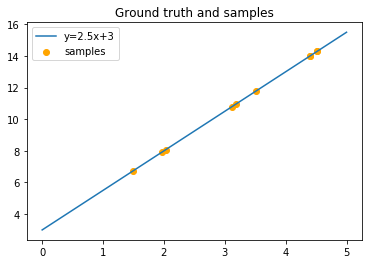

In [5]:
fig, ax = plt.subplots(1,1)
ax.scatter(x, y, label='samples', color='orange')
ax.plot(x_plot, y_plot, label='y={}x+{}'.format(a,b))
ax.legend()
plt.title("Ground truth and samples")
plt.show()

pytorch use ``torch.tensor`` object to store, process tensor. Here we are going to convert ``np.array`` data points `x, y` into the ``torch.tensor``.

(Note) we can use either `torch.tensor` or `torch.Tensor`. The result will be slighltly differnt depending on input data's type.


In [37]:
x_tensor = torch.Tensor(x)
y_tensor = torch.Tensor(y)

## Do forward propagation 

In [38]:
INPUT_SIZE = 1
HIDDEN_SIZE = 3
OUTPUT_SIZE = 1

model = MultiLayerPerceptron(input_dim=INPUT_SIZE, 
                             hidden_dim=HIDDEN_SIZE, 
                             output_dim=OUTPUT_SIZE)

print(model)

MultiLayerPerceptron(
  (input_layer): Linear(in_features=1, out_features=3, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (hidden_layer): Linear(in_features=3, out_features=3, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (output_layer): Linear(in_features=3, out_features=1, bias=True)
)


In [39]:
model.forward(x_tensor) # or equivalently model(x_tensor) torch.nn.module overload __call__ method of python object with forward()

RuntimeError: size mismatch, m1: [1 x 10], m2: [1 x 3] at ..\aten\src\TH/generic/THTensorMath.cpp:961

You will get the following error:

RuntimeError: size mismatch, m1: [1 x 10], m2: [1 x 2] at ..\aten\src\TH/generic/THTensorMath.cpp:961

## WHY ??

Reason: ``torch.nn.module`` presumes that __the first dimension__ is reserved for batch index.

<center><img src="img/1d_tensor.png" width="500" height="300"><em>Rank 1 Tensor</em></center>

In [40]:
print('The shape of tensor is : {}'.format(x_tensor.shape))

The shape of tensor is : torch.Size([10])


Currently, our tensor is rank 1. That is our model infers 'oh! there exist __10 samples__ with 0 dimension' <br/>
*That is mini batch size is __10__.

__Note)__ Easily speaking, the rank of tensor is equivalent to the number of index to specify certrain cell in the tensor. In this case, we only need 1 index to point the element of tensor.

Then how to make rank 2 tensor (or simply let say __2d tensor__ - not exactly correct term :p)

<center><img src="img/2d_tensor.png" width="500" height="300"><em>Rank 2 Tensor</em></center>

In [42]:
x_tensor_2d = x_tensor.reshape(n_samples, INPUT_SIZE) # reshape the tensor to expand the dimension of tensor
y_tensor_2d = y_tensor.reshape(n_samples, OUTPUT_SIZE)

In [43]:
print('The shape of tensor is : {}'.format(x_tensor_2d.shape))

The shape of tensor is : torch.Size([10, 1])


## Do forward again!

In [12]:
y_pred = model.forward(x_tensor_2d)

`y_pred` contains the result of forward propagation. Let's check the dimension of `y_pred`.

In [13]:
print('The shape of tensor is : {}'.format(y_pred.shape))

The shape of tensor is : torch.Size([10, 1])


## Visualize the prediction results

`tensor` object, by default, attatches to the computaional graph of pytorch to support graident computation.
* Therefore, we firstly need to detach tensors from the computational graph by using `detach()` method.
* And then convert `tensor` object to `numpy.array` for visualizing with `numpy()` method.

In [14]:
y_pred_numpy = y_pred.detach().numpy()

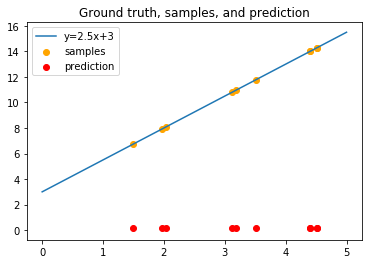

In [15]:
fig, ax = plt.subplots(1,1)
ax.scatter(x, y, label='samples', color='orange')
ax.scatter(x, y_pred_numpy, label='prediction', color='red')
ax.plot(x_plot, y_plot, label='y={}x+{}'.format(a,b))
ax.legend()
plt.title("Ground truth, samples, and prediction")
plt.show()

Now, we need to define __train__ routine. The routine has majory two parts:
* Define loss function
* Define optimizer
* Backpropagation and update graidents

In this tutorial, we will use Mean Square Error as the trainig loss. <br/>
$$\text{MSE}(\hat{y},y) = \sum_i (\hat{y}_i- y_i)^2$$
$$\text{where} \ \hat{y}_i = \text{MLP}(x_i), y_i = \text{target}$$

In [16]:
loss_fn = torch.nn.MSELoss()

In this tutorial, we employ vanilla version SGD (Stochastic Gradient Descent) optimizer to update the models gradient.You can easily instantiate the optimizer with the following code.

* `lr` is the learning rate (or step size) of the optimizer
* `model.parameters()` is a python generator which return the paraemters of our model. <br/>
__(Note)__ We can pass subset of paramters if necessary. If we pass the subset of parameters to the optimizer, then the optimizer only updates the paremeters of subsets.
* `zero_grad()` method prepares the 0 values of the target paratmers as the inital value of the partial derivatives. __Please do not forget to call this method before computing partial derivatives__ 

In [17]:
opt = torch.optim.SGD(model.parameters(), lr=0.001)
opt.zero_grad()

In [18]:
loss = loss_fn(y_pred, y_tensor_2d)
print("Current loss is : {}".format(loss))

Current loss is : 130.9924774169922


Now we defined data, model, and loss function and evaluate the loss. So we are now ready to compute partial derivatives of the loss with respect to the parameters in MLP. <br/>
Q) How can we perform backpropgation on computational graph? <br/>
A) Super easy. Just call the `backward` method. <br/>

Before we proceed to backpropgation, take a look the __weight__ and __bias__ paramters of the input layer.

In [19]:
print('============ Weight ============ \n', model.input_layer.weight)
print('============ Bias ============ \n', model.input_layer.bias)

============ Weight ============ 
 Parameter containing:
tensor([[-0.0826],
        [ 0.6527],
        [-0.7737]], requires_grad=True)
============ Bais ============ 
 Parameter containing:
tensor([-0.2600,  0.1492,  0.3868], requires_grad=True)


`requires_grad = True` indicates that 'when they get backpropagated by any mean, pytorch compute the partial derivative of the `requires_grad = True` tensor.

In [20]:
loss.backward() # compute the partial derivatives`

In [21]:
opt.step() # update the parameters with the partial derivatives

In [22]:
print('============ Weight ============ \n', model.input_layer.weight)
print('============ Bias ============ \n', model.input_layer.bias)

============ Weight ============ 
 Parameter containing:
tensor([[-0.0826],
        [ 0.6554],
        [-0.7737]], requires_grad=True)
============ Bais ============ 
 Parameter containing:
tensor([-0.2600,  0.1500,  0.3868], requires_grad=True)


## Visualize the updated prediction results

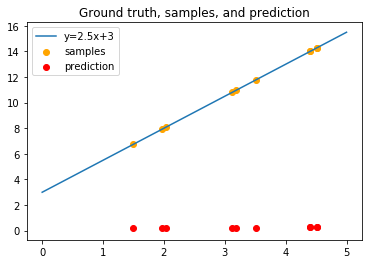

In [23]:
y_pred = model.forward(x_tensor_2d)
y_pred_numpy = y_pred.detach().numpy()

fig, ax = plt.subplots(1,1)
ax.scatter(x, y, label='samples', color='orange')
ax.scatter(x, y_pred_numpy, label='prediction', color='red')
ax.plot(x_plot, y_plot, label='y={}x+{}'.format(a,b))
ax.legend()
plt.title("Ground truth, samples, and prediction")
plt.show()

## Perform multi-step gradient updates

Figure above demonstrates the 1 step updated model's prediciton results. As we can see from the figure, 1 step update is not enough. Then why don't we perform multiple steps of gradient update?

Hereby, we would coin a term, epoch. 1 epoch indicates training procedure that the model updates the parameter with entire dataset 1 times.

In [24]:
def visualize_prediction(y_pred):
    fig, ax = plt.subplots(1,1)
    ax.scatter(x, y, label='samples', color='orange')
    ax.scatter(x, y_pred, label='prediction', color='red')
    ax.plot(x_plot, y_plot, label='y={}x+{}'.format(a,b))
    ax.legend()
    plt.title("Ground truth, samples, and prediction")
    plt.show()

============ train 0 th epoch ============


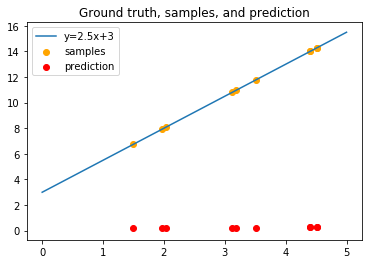

============ train 20 th epoch ============


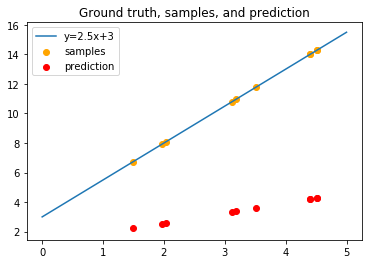

============ train 40 th epoch ============


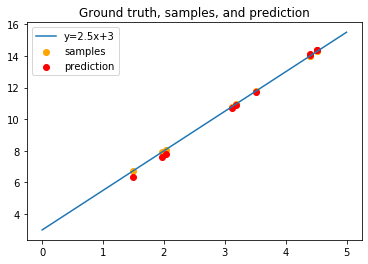

============ train 60 th epoch ============


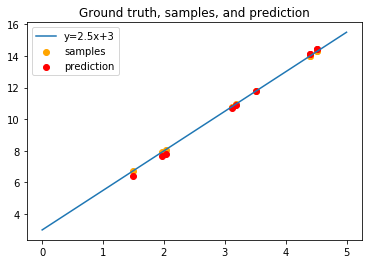

============ train 80 th epoch ============


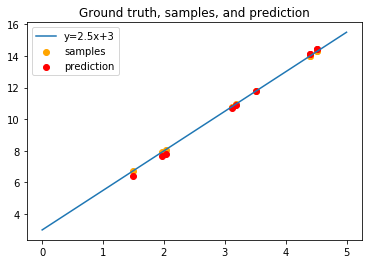

In [25]:
n_epoch = 100
visualize_every = 20

for i in range(n_epoch):
    y_pred = model.forward(x_tensor_2d)
    loss = loss_fn(y_pred, y_tensor_2d)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i % visualize_every == 0:
        print("============ train {} th epoch ============".format(i))
        visualize_prediction(y_pred.detach().numpy())

## Validating model without visual aid

Visual interpretation is intuitive and works well. However, is there quantative manner to measure the performance of the model? Yes. Use __validation__ metric.

In this tutorial, we will use MAPE (Mean Absolute Percentage Error) as the validation metric <br/>
$$\text{MAPE}(\hat{y},y) = \frac{100\%}{n}\sum_i^n|\frac{y_i-\hat{y}_i}{y_i}|^2 $$
$$\text{where} \ \hat{y}_i = \text{MLP}(x_i), y_i = \text{target}$$

In [26]:
class MAPE:
    def __call__(self, pred, target):
        return torch.abs((target - pred) / target).mean() * 100


In [44]:
model = MultiLayerPerceptron(input_dim=1, 
                             hidden_dim=3, 
                             output_dim=1)

loss_fn = torch.nn.MSELoss()
val_fn = MAPE()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

n_epoch = 100
report_every = 10

for i in range(n_epoch+1):
    y_pred = model.forward(x_tensor_2d)
    loss = loss_fn(y_pred, y_tensor_2d)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i % report_every == 0:
        train_loss = loss.item()
        validation_score = val_fn(y_pred, y_tensor_2d)
        print("[{}/{}] train loss : {:.3f} validation score : {:.3f} %".format(i, 
                                                                               n_epoch,
                                                                               train_loss, 
                                                                               validation_score))

[0/100] train loss : 134.745 validation score : 99.905 %
[10/100] train loss : 129.744 validation score : 97.778 %
[20/100] train loss : 124.940 validation score : 95.694 %
[30/100] train loss : 120.324 validation score : 93.650 %
[40/100] train loss : 115.889 validation score : 91.647 %
[50/100] train loss : 111.629 validation score : 89.684 %
[60/100] train loss : 107.536 validation score : 87.760 %
[70/100] train loss : 103.604 validation score : 85.874 %
[80/100] train loss : 99.826 validation score : 84.025 %
[90/100] train loss : 96.197 validation score : 82.213 %
[100/100] train loss : 92.710 validation score : 80.437 %


## Why we use `torch.nn.Module` ?

We __can__ define the model and design the forward path without using `torch.nn.Module`.
Then what is the reason that we use `torch.nn.Module` for defining models?

The truth is `torch.nn.Module` supports usefull features.
* __train / evaluation mode__ Recall dropout, batch normalization. Those methods perform differently when the model is on training and evaluating. 
* __support syntax sugar for moving CPU tensor to GPU tensor and so forth__
* Automatic module registrations
* ...

In [28]:
model.train()
print('Model is train mode ?', model.training)

Model is train mode ? True


In [29]:
model.eval()
print('Model is evaluation mode ?', not(model.training))

Model is evaluation mode ? True


GPU is now indeed primary computation speed boosting tool right now. (For tensorflow, TPU is also available option) <br/> Then how can we exploit GPU to boosting compuation time of pytorch?

In [30]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda_avail = torch.cuda.is_available()

In [31]:
device

'cpu'

We can move the tensors on CPU to GPU by calling the method `to`. Now we will inspect how much computation is getting faster on GPU.

In [32]:
model.to(device)
x_tensor_2d = x_tensor_2d.to(device)
y_tensor_2d = y_tensor_2d.to(device)

num_rep = 10
gpu_times = [] 

for t in range(num_rep):
    print("Start {} th repeatation".format(t))
    s_time = time()
    n_epoch = 100
    report_every = 100

    for i in range(n_epoch+1):
        y_pred = model.forward(x_tensor_2d)
        loss = loss_fn(y_pred, y_tensor_2d)
        opt.zero_grad()
        loss.backward()
        opt.step()

    time_elapsed = time() - s_time
    gpu_times.append(time_elapsed)

Start 0 th repeatation
Start 1 th repeatation
Start 2 th repeatation
Start 3 th repeatation
Start 4 th repeatation
Start 5 th repeatation
Start 6 th repeatation
Start 7 th repeatation
Start 8 th repeatation
Start 9 th repeatation


In [33]:
gpu_times = np.array(gpu_times)
print("Fitting with GPU takes {} secs on average. std. {} secs".format(np.mean(gpu_times), np.std(gpu_times)))

Fitting with GPU takes 0.04697427749633789 secs on average. std. 0.005303305753717549 secs


In [34]:
device = 'cpu'

model.to(device)
x_tensor_2d = x_tensor_2d.to(device)
y_tensor_2d = y_tensor_2d.to(device)

num_rep = 10
cpu_times = [] 

for t in range(num_rep):
    print("Start {} th repeatation".format(t))
    s_time = time()
    n_epoch = 100
    report_every = 100

    for i in range(n_epoch+1):
        y_pred = model.forward(x_tensor_2d)
        loss = loss_fn(y_pred, y_tensor_2d)
        opt.zero_grad()
        loss.backward()
        opt.step()

    time_elapsed = time() - s_time
    cpu_times.append(time_elapsed)

Start 0 th repeatation
Start 1 th repeatation
Start 2 th repeatation
Start 3 th repeatation
Start 4 th repeatation
Start 5 th repeatation
Start 6 th repeatation
Start 7 th repeatation
Start 8 th repeatation
Start 9 th repeatation


In [35]:
cpu_times = np.array(cpu_times)
print("Fitting with CPU takes {} secs on average. std. {} secs".format(np.mean(cpu_times), np.std(cpu_times)))

Fitting with CPU takes 0.04667255878448486 secs on average. std. 0.002924327584230113 secs
